# Telecom

# Creating a Telecom project plan - predicting customer churn

The telecom operator wants to learn how to predict the outflow of customers. If it turns out that the user is planning to leave, he will be offered promo codes and special conditions. The operator's team collected personal data about some customers, information about their tariffs and contracts.

## Data description

There are 4 files:

- `contract_new.csv` — contract information;
- `personal_new.csv` — personal data of customers;
- `internet_new.csv` — information about internet services;
- `phone_new.csv` — information about telephone services.

In [46]:
#!pip install phik
#pip install ipywidgets
#pip install -U scikit-learn
#pip install ipywidgets
#pip install imbalanced-learn

In [47]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import phik
import warnings
import sklearn
import shap
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from phik.report import plot_correlation_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import (
                                    GridSearchCV,
                                    train_test_split
                                    )
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,  roc_auc_score
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
import catboost
from catboost import Pool, cv
from catboost.utils import get_roc_curve
from sklearn import metrics
from sklearn.inspection import permutation_importance

In [48]:
warnings.filterwarnings('ignore')
sns.set()
sns.set_style("whitegrid")

In [49]:
try:
    df_contract = pd.read_csv('contract_new.csv',parse_dates=['BeginDate'],index_col='customerID')
    df_internet = pd.read_csv('internet_new.csv',index_col='customerID')
    df_personal = pd.read_csv('personal_new.csv',index_col='customerID')
    df_phone    = pd.read_csv('phone_new.csv',index_col='customerID')
except:
    df_contract = pd.read_csv('/datasets/contract_new.csv',parse_dates=['BeginDate'],index_col='customerID')
    df_internet = pd.read_csv('/datasets/internet_new.csv',index_col='customerID')
    df_personal = pd.read_csv('/datasets/personal_new.csv',index_col='customerID')
    df_phone    = pd.read_csv('/datasets/phone_new.csv',index_col='customerID')

In [50]:
df = {'contract': df_contract,
      'internet':df_internet,
      'person':df_personal,
      'phone':df_phone}
for d in df.values():
    d.columns = d.columns.str.lower()

### Contract

The first table contains information about **contracts**

- CustomerId - ID
- BeginDate - start date of service usage
- EndDate - end date of service usage
- Type - payment type: monthly, yearly, etc.
- PaperlessBilling - paperless billing option (yes/no)
- PaymentMethod - payment method
- MonthlyCharges - monthly charges for services
- TotalCharges - total amount spent on services

In [51]:
df['contract'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   begindate         7043 non-null   datetime64[ns]
 1   enddate           7043 non-null   object        
 2   type              7043 non-null   object        
 3   paperlessbilling  7043 non-null   object        
 4   paymentmethod     7043 non-null   object        
 5   monthlycharges    7043 non-null   float64       
 6   totalcharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 440.2+ KB


In [52]:
df['contract'].duplicated().sum()

37

We can see that type of **totalcharges** is 'object' while it should be 'float' 

In [53]:
df['contract'].describe()

,monthlycharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


### Internet

In [54]:
df['internet'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   internetservice   5517 non-null   object
 1   onlinesecurity    5517 non-null   object
 2   onlinebackup      5517 non-null   object
 3   deviceprotection  5517 non-null   object
 4   techsupport       5517 non-null   object
 5   streamingtv       5517 non-null   object
 6   streamingmovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


In [55]:
df['internet'].duplicated().sum()

5389

### Person

- Dependents - presence of dependents
- Senior Citizen - presence of senior citizen status based on age
- Partner - presence of a partner/spouse

In [56]:
df['person'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   seniorcitizen  7043 non-null   int64 
 2   partner        7043 non-null   object
 3   dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB


In [57]:
df['person'].duplicated().sum()

7027

### Phone

- MultipleLines – the ability to conduct parallel lines during a phone call

In [58]:
df['phone'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   multiplelines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


In [59]:
df['phone'].duplicated().sum()

6359

### Conclusion

Although the data is filled without missing values and explicit duplicates, it contains errors in the filling with the "type" field. It is also evident that the number of contracts exceeds the number of values in the "phone" and "internet" tables, which may indicate missing values and that the customer is only a user of one service. It is also worth checking for implicit duplicates, examining unique values, and analyzing the distribution.

## Project plan

1. Data exploration and initial data processing:

- Examine all fields: remove duplicates, study unique values, filter anomalies, etc.
- Show necessary plots and charts.
- Draw conclusions.

2. Data processing and preparation:

- Encode variables if necessary.
- Plot a correlation matrix.
- Select relevant features.
- Split the dataset into training and testing sets.

3. Model selection and training:

- Consider suitable metrics and loss functions for training.
- Train a linear regression model to assess feature importance (potentially eliminate some features).
- Train an interpretable model such as a decision tree, or more likely, a random forest.
- Choose and train a gradient boosting model.
- Select the best model based on validation results.

4. Model evaluation:

- Test the selected model.
- Plot ROC-AUC curves and calculate relevant metrics.
- Draw final conclusions.

# Data preparation

Due to the fact that the tables contain a small number of fields, we will merge them all into one table. The table with contracts is the main one, so let's merge the contract tables by indexes. But first we will prepare each table separately

## Contract

Since many features are categorical, let's consider the unique values of such fields

In [60]:
for i in df_contract.columns:
    if df_contract[i].dtype == 'O':
        print(i,'\n',df_contract[i].unique())

enddate 
 ['No' '2017-05-01' '2016-03-01' '2018-09-01' '2018-11-01' '2018-12-01'
 '2019-08-01' '2018-07-01' '2017-09-01' '2015-09-01' '2016-07-01'
 '2016-06-01' '2018-03-01' '2019-02-01' '2018-06-01' '2019-06-01'
 '2020-01-01' '2019-11-01' '2016-09-01' '2015-06-01' '2016-12-01'
 '2019-05-01' '2019-04-01' '2017-06-01' '2017-08-01' '2018-04-01'
 '2018-08-01' '2018-02-01' '2019-07-01' '2015-12-01' '2014-06-01'
 '2018-10-01' '2019-01-01' '2017-07-01' '2017-12-01' '2018-05-01'
 '2015-11-01' '2019-10-01' '2019-03-01' '2016-02-01' '2016-10-01'
 '2018-01-01' '2017-11-01' '2015-10-01' '2019-12-01' '2015-07-01'
 '2017-04-01' '2015-02-01' '2017-03-01' '2016-05-01' '2016-11-01'
 '2015-08-01' '2019-09-01' '2017-10-01' '2017-02-01' '2016-08-01'
 '2016-04-01' '2015-05-01' '2014-09-01' '2014-10-01' '2017-01-01'
 '2015-03-01' '2015-01-01' '2016-01-01' '2015-04-01' '2014-12-01'
 '2014-11-01']
type 
 ['Month-to-month' 'One year' 'Two year']
paperlessbilling 
 ['Yes' 'No']
paymentmethod 
 ['Electronic che

Мы видем две особенности таблицы, не смотря на то что поля **enddate** и **totalcharges** должны быть типа дата и число, они тоже являются строковыми переменными. Если **enddate** имеет No, что говорит о том что клиент еще пользуется. А вот с **totalcharges** непонятно. Изучим более подробно


We observe two peculiarities in the table. Despite the fact that the fields **enddate** and **totalcharges** should be of date and numeric types, respectively, they are also string variables. If **enddate** has a value of "No," it indicates that the client is still using the service. However, the nature of **totalcharges** is unclear. Let's examine it in more detail.

In [61]:
list_to_remove = []
for i in range(df_contract['totalcharges'].shape[0]):
    try:
        float(df_contract['totalcharges'][i])
    except:
        display(df_contract.iloc[i].to_frame())
        print('value =',df_contract['totalcharges'][i])
        list_to_remove.append(i)

,4472-LVYGI
begindate,2020-02-01 00:00:00
enddate,No
type,Two year
paperlessbilling,Yes
paymentmethod,Bank transfer (automatic)
monthlycharges,52.55
totalcharges,


value =  


,3115-CZMZD
begindate,2020-02-01 00:00:00
enddate,No
type,Two year
paperlessbilling,No
paymentmethod,Mailed check
monthlycharges,20.25
totalcharges,


value =  


,5709-LVOEQ
begindate,2020-02-01 00:00:00
enddate,No
type,Two year
paperlessbilling,No
paymentmethod,Mailed check
monthlycharges,80.85
totalcharges,


value =  


,4367-NUYAO
begindate,2020-02-01 00:00:00
enddate,No
type,Two year
paperlessbilling,No
paymentmethod,Mailed check
monthlycharges,25.75
totalcharges,


value =  


,1371-DWPAZ
begindate,2020-02-01 00:00:00
enddate,No
type,Two year
paperlessbilling,No
paymentmethod,Credit card (automatic)
monthlycharges,56.05
totalcharges,


value =  


,7644-OMVMY
begindate,2020-02-01 00:00:00
enddate,No
type,Two year
paperlessbilling,No
paymentmethod,Mailed check
monthlycharges,19.85
totalcharges,


value =  


,3213-VVOLG
begindate,2020-02-01 00:00:00
enddate,No
type,Two year
paperlessbilling,No
paymentmethod,Mailed check
monthlycharges,25.35
totalcharges,


value =  


,2520-SGTTA
begindate,2020-02-01 00:00:00
enddate,No
type,Two year
paperlessbilling,No
paymentmethod,Mailed check
monthlycharges,20.0
totalcharges,


value =  


,2923-ARZLG
begindate,2020-02-01 00:00:00
enddate,No
type,One year
paperlessbilling,Yes
paymentmethod,Mailed check
monthlycharges,19.7
totalcharges,


value =  


,4075-WKNIU
begindate,2020-02-01 00:00:00
enddate,No
type,Two year
paperlessbilling,No
paymentmethod,Mailed check
monthlycharges,73.35
totalcharges,


value =  


,2775-SEFEE
begindate,2020-02-01 00:00:00
enddate,No
type,Two year
paperlessbilling,Yes
paymentmethod,Bank transfer (automatic)
monthlycharges,61.9
totalcharges,


value =  


**Conclusion:** we see that 11 customers have not made a payment, there is a gap instead, because they have just started using the service. We will delete such clients, they will not contribute any useful information

In [62]:
df_contract = df_contract[df_contract['totalcharges'] != ' ']
df_contract['totalcharges'] = df_contract['totalcharges'].astype(float)

Let's convert **enddate** to a date format, replace "No" with the latest date, and also make the target feature indicate whether the client is using the service or not. 

In [63]:
df_contract['user'] = int(0) 
df_contract['user'][df_contract['enddate'] != 'No'] = int(1)
df_contract['enddate'][df_contract['enddate'] == 'No'] = '2020-02-01'
df_contract['enddate'] = pd.to_datetime(df_contract['enddate'], format="%Y-%m-%d")
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   begindate         7032 non-null   datetime64[ns]
 1   enddate           7032 non-null   datetime64[ns]
 2   type              7032 non-null   object        
 3   paperlessbilling  7032 non-null   object        
 4   paymentmethod     7032 non-null   object        
 5   monthlycharges    7032 non-null   float64       
 6   totalcharges      7032 non-null   float64       
 7   user              7032 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(1), object(3)
memory usage: 494.4+ KB


Now let's calculate the duration of service usage.

In [64]:
df_contract['using_time'] =  (df_contract['enddate'] - df_contract['begindate']).dt.days
df_contract = df_contract.drop(['enddate','begindate'],axis=1)

In [65]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   type              7032 non-null   object 
 1   paperlessbilling  7032 non-null   object 
 2   paymentmethod     7032 non-null   object 
 3   monthlycharges    7032 non-null   float64
 4   totalcharges      7032 non-null   float64
 5   user              7032 non-null   int64  
 6   using_time        7032 non-null   int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 439.5+ KB


Explore each field more precisely 

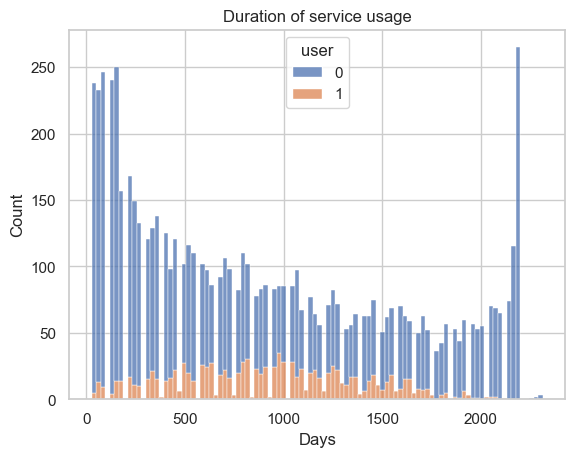

In [66]:
sns.histplot(df_contract, x='using_time', hue='user',bins=100, multiple="stack")
plt.title('Duration of service usage')
plt.xlabel('Days')
plt.show()

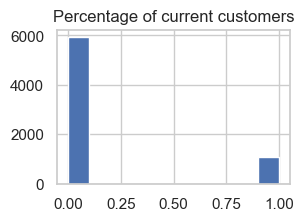

0    0.84
1    0.16
Name: user, dtype: float64

In [67]:
plt.figure(figsize=(3,2))
df_contract['user'].hist()
plt.title('Percentage of current customers')
plt.show()
round(df_contract['user'].value_counts() / len(df_contract['user']),2)

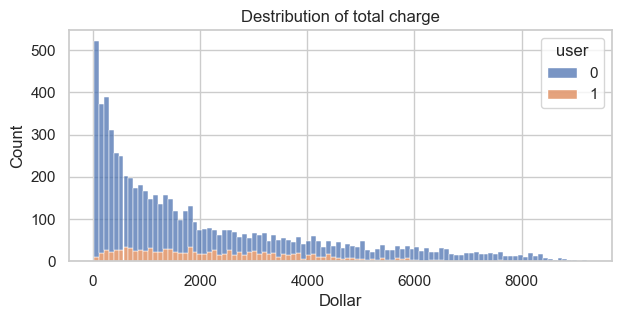

In [68]:
plt.figure(figsize=(7,3))
sns.histplot(df_contract, x='totalcharges', hue='user',bins=100, multiple="stack")
plt.title('Destribution of total charge')
plt.xlabel('Dollar')
plt.show()

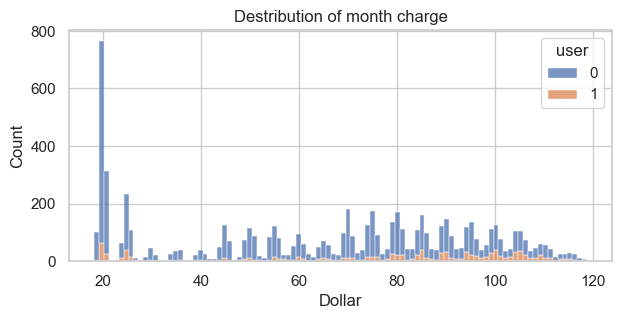

In [69]:
plt.figure(figsize=(7,3))
sns.histplot(df_contract, x='monthlycharges', hue='user',bins=100, multiple="stack")
plt.title('Destribution of month charge')
plt.xlabel('Dollar')
plt.show()

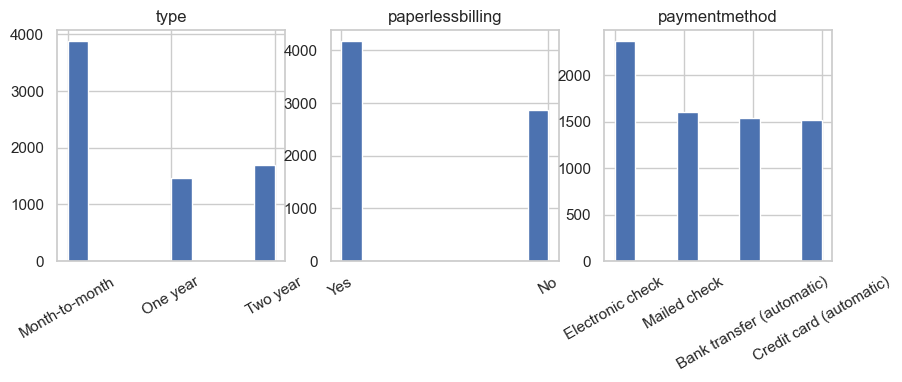

In [70]:
fig, ax = plt.subplots(1,3, figsize = (10,3),)
ax = ax.flatten()
for i,j in zip(df_contract.columns[:3],ax):
    df_contract[i].hist(ax=j,xrot=30)
    j.set_title(i)

**Conclusion on the Contract table:**

The data has been prepared, and the start and end dates have been replaced with the duration of service usage. A target feature indicating whether the customer is using the service or not has been added, and the data has been converted to the appropriate data type. No missing values or duplicates were found.

- The distribution of service usage time shows that the number of customers increases over time. There is a peak around 2000 days, indicating a group of loyal customers from the company's inception. The distribution by groups indicates that if a customer uses the company's services for more than 700-800 days, they become loyal and do not churn, as indicated by the plateau. The distribution of churned customers forms a bell-shaped curve with a peak around 1000 days. One notable characteristic is the presence of multiple peaks, suggesting a significant variation in customer behavior.
- The ratio of churned customers to active customers is approximately 1/5 (16% and 84% respectively).
- Monthly charges show approximately 18 peaks, indicating the presence of different tariff plans or variations in additional services.
- More than half of the contracts are on a month-to-month basis.
- Approximately 40% of customers pay with cash.

## Internet

In [71]:
df_internet.head()

,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No


In [72]:
for i in df_internet.columns:
    display(df_internet[i].value_counts())

Fiber optic    3096
DSL            2421
Name: internetservice, dtype: int64

No     3498
Yes    2019
Name: onlinesecurity, dtype: int64

No     3088
Yes    2429
Name: onlinebackup, dtype: int64

No     3095
Yes    2422
Name: deviceprotection, dtype: int64

No     3473
Yes    2044
Name: techsupport, dtype: int64

No     2810
Yes    2707
Name: streamingtv, dtype: int64

No     2785
Yes    2732
Name: streamingmovies, dtype: int64

**Вывод по Internet:** В данных нет пропусков и дубликатов

## Person и Phone

In [73]:
df_personal.head()

,gender,seniorcitizen,partner,dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No


In [74]:
for i in df_personal.columns:
    display(df_personal[i].value_counts())

Male      3555
Female    3488
Name: gender, dtype: int64

0    5901
1    1142
Name: seniorcitizen, dtype: int64

No     3641
Yes    3402
Name: partner, dtype: int64

No     4933
Yes    2110
Name: dependents, dtype: int64

In [75]:
df_phone.value_counts()

multiplelines
No               3390
Yes              2971
dtype: int64

**Conclusion:** tables are prepared to merging

Left join by indexes, the main table - **contract**

In [76]:
df_all = df_contract.join(pd.concat([df_internet, df_personal,df_phone],axis=1),how='left')
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   type              7032 non-null   object 
 1   paperlessbilling  7032 non-null   object 
 2   paymentmethod     7032 non-null   object 
 3   monthlycharges    7032 non-null   float64
 4   totalcharges      7032 non-null   float64
 5   user              7032 non-null   int64  
 6   using_time        7032 non-null   int64  
 7   internetservice   5512 non-null   object 
 8   onlinesecurity    5512 non-null   object 
 9   onlinebackup      5512 non-null   object 
 10  deviceprotection  5512 non-null   object 
 11  techsupport       5512 non-null   object 
 12  streamingtv       5512 non-null   object 
 13  streamingmovies   5512 non-null   object 
 14  gender            7032 non-null   object 
 15  seniorcitizen     7032 non-null   int64  
 16  partner           7032 non-null 

It can be seen that the merging of the tables led to the presence of omissions in categorical features, since the services in these fields were not used. Replace the gaps with "No"

In [77]:
df_all.fillna('No',inplace=True)

The data is prepared for sample separation, encoding and scaling. The test sample will contain 25% of the total population

interval columns not set, guessing: ['monthlycharges', 'totalcharges', 'user', 'using_time', 'seniorcitizen']


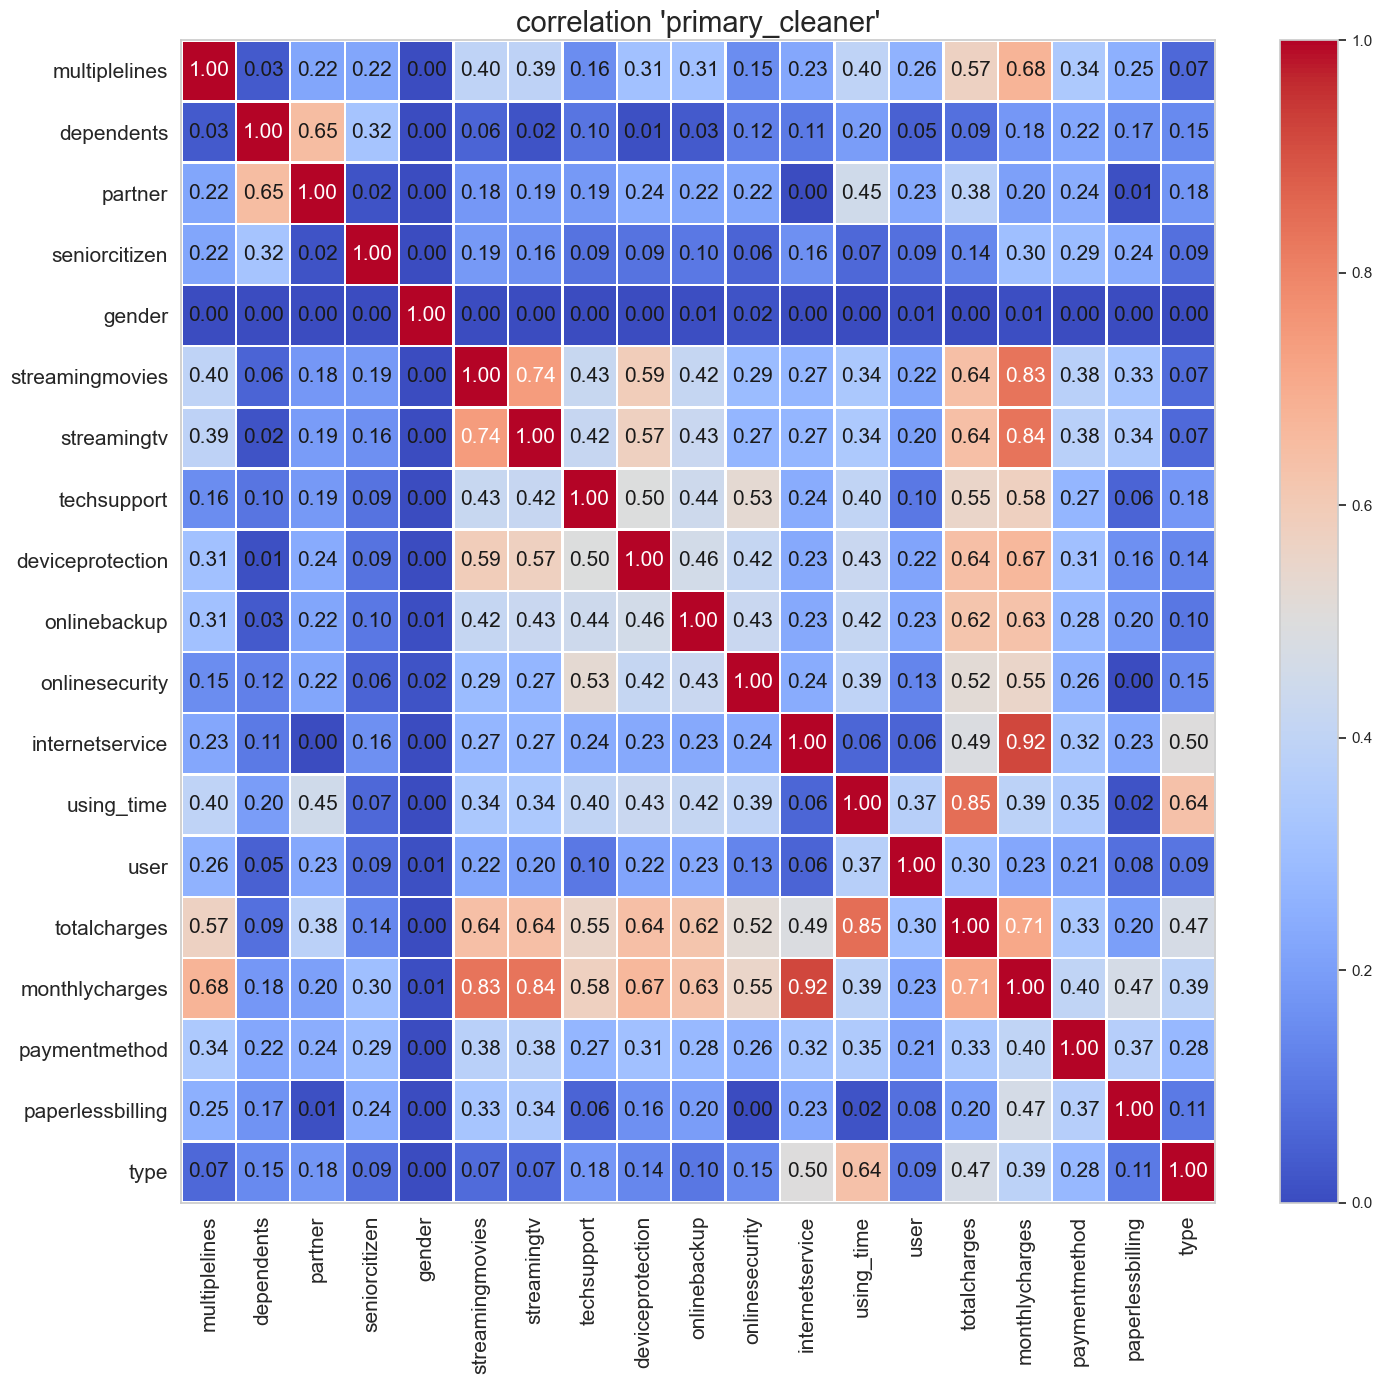

In [78]:
phik_overview = df_all.phik_matrix()
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, 
                        color_map='coolwarm',
                        title=r"correlation 'primary_cleaner'", 
                        fontsize_factor=1.5, 
                        figsize=(15, 14))

Let's select the features that are not correlated with the target **user**: dependents, gender, seniorcitizen, internetservice, type, and paperlessbilling. We will remove these columns. Additionally, there are other correlated features, and since **monthlycharges** correlates with many of them, we will remove it as well. We will also remove the **totalcharges** column since it is logically highly related to the duration of usage and whether there are additional service charges. As there is an imbalance in the data, we should remember to include stratify=target to ensure stratified sampling.

In [79]:
RANDOM_STATE = 80523
feature = df_all.drop(['user','type', 'paperlessbilling',
                       'internetservice','seniorcitizen',
                       'gender','dependents',
                       'totalcharges','monthlycharges'],axis=1)
target = df_all['user'] 
x_train, x_test, y_train, y_test = train_test_split(feature, target, test_size=0.25, random_state=RANDOM_STATE, stratify=target)

In [80]:
x_train.shape

(5274, 10)

In [81]:
x_test.shape

(1758, 10)

We will encode and scale the data. For encoding, we will use **OneHotEncoder**. For scaling, we will use **RobustScaler** since the data is not normally distributed, contains outliers, and has distinct peaks. It is important to preserve these characteristics during scaling.

In [82]:
#составим списки с числовыми и символьными признаками
columns_o = x_train.select_dtypes(include='object').columns.to_list()
columns_n = x_train.select_dtypes(exclude='object').columns.to_list()

scale = RobustScaler()
scale.fit(x_train[columns_n])
x_train[columns_n] = scale.transform(x_train[columns_n])
x_test[columns_n] = scale.transform(x_test[columns_n])

#енкодер для символьных столбцов
oe = make_column_transformer(
        (OneHotEncoder(), columns_o),
         remainder='drop',)
x_train_oe = oe.fit_transform(x_train)
x_test_oe = oe.transform(x_test)

**Final conclusion:** During the data preparation and analysis, the following steps were performed:

- Tables were merged, missing values were filled, and data was divided taking into account the class imbalance.
- Encoding and scaling techniques were applied to the features.

By completing these steps, the data is now ready for further analysis and modeling.

# Model selection and training

First, tain linear model

In [83]:
model_lr = LogisticRegression(random_state=RANDOM_STATE)

col_transformer = make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'),
        columns_o
    ),
    remainder='passthrough',
    verbose_feature_names_out=False
)

x_train_lr = pd.DataFrame(
    col_transformer.fit_transform(x_train),
    columns=col_transformer.get_feature_names_out()
)

cv_lr = cross_val_score(model_lr,
                        x_train_oe,
                        y_train,
                        scoring='roc_auc',)
print("Mean score: ", round(cv_lr.mean(),2))

Mean score:  0.71


Let's train a model of a **random forest**. According to the recommendations, when training a forest, it is better not to drop the first value in the parameters when encoding onehotencoder (drop_first=True decreases a score by 0.01).

In [84]:
%%time
model_forest = RandomForestClassifier(class_weight={0: 7, 1: 1}, random_state=RANDOM_STATE)
col_transformer = make_column_transformer(
    (
        OneHotEncoder(handle_unknown='ignore'),
        columns_o
    ),
    remainder='passthrough',
    verbose_feature_names_out=False
)
pipeline_forest = make_pipeline(col_transformer, model_forest)
parameters = {'randomforestclassifier__n_estimators': range(100, 300, 20),
              'randomforestclassifier__max_depth': range(4, 12),
             }
gs_ridge_forest = GridSearchCV(
    pipeline_forest, 
    param_grid=parameters, 
    scoring='roc_auc', 
    n_jobs=-1)
gs_ridge_forest.fit(x_train, y_train)

CPU times: total: 5.39 s
Wall time: 1min 11s


GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['paymentmethod',
                                                                          'onlinesecurity',
                                                                          'onlinebackup',
                                                                          'deviceprotection',
                                                                          'techsupport',
                                                                          'streamingtv',
                                                                          'streamingmovies',
                                                                          'partner',
                                                                          'multiplelines'])],
                                                          verbose_feature_names_out=False)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(class_weight={0: 7,
                                                                             1: 1},
                                                               random_state=80523))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(4, 12),
                         'randomforestclassifier__n_estimators': range(100, 300, 20)},
             scoring='roc_auc')

In [85]:
gs_rf_best_score = gs_ridge_forest.best_score_ 
gs_rf_best_params = gs_ridge_forest.best_params_
print(f'best_roc_auc: {round(gs_rf_best_score,3)}')
print(f'best_params: {gs_rf_best_params}')

best_roc_auc: 0.794
best_params: {'randomforestclassifier__max_depth': 6, 'randomforestclassifier__n_estimators': 160}


The best results were given by the forest with the number of 160 trees and a depth of 6 with a result of 0.8

In [86]:
cat_features = x_train.columns.get_indexer(columns_o)
pool = Pool(data=x_train.values, label=y_train.values,cat_features=cat_features)

In [94]:
params = {
    'loss_function': 'Logloss',
    'iterations': 180,
    'eval_metric': 'AUC',
    'random_seed': RANDOM_STATE,
    'learning_rate': 0.5,
    'early_stopping_rounds':10,
    
}

cv_data = cv(
    params=params,
    pool=pool,
    fold_count=5, 
    shuffle=True, 
    partition_random_seed=RANDOM_STATE,
    stratified=True, 
    verbose_eval=False,
    plot=False,
)

Training on fold [0/5]

bestTest = 0.9314132936
bestIteration = 59

Training on fold [1/5]

bestTest = 0.9171024855
bestIteration = 65

Training on fold [2/5]

bestTest = 0.9401804562
bestIteration = 55

Training on fold [3/5]

bestTest = 0.9144629649
bestIteration = 79

Training on fold [4/5]

bestTest = 0.9225210485
bestIteration = 65



In [88]:
cv_data.sort_values(by='test-AUC-mean',ascending=False).head(5)

,iterations,test-AUC-mean,test-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
65,65,0.923637,0.010711,0.218156,0.014010,0.148908,0.005391
64,64,0.923458,0.011023,0.218592,0.014371,0.150242,0.005494
71,71,0.923282,0.011086,0.217407,0.013761,0.144224,0.007667
63,63,0.923254,0.011526,0.218872,0.015173,0.152179,0.005722
79,79,0.923210,0.010585,0.216731,0.013026,0.141215,0.010527


**Conclusion on model selection:** The CatBoost classifier demonstrated a significant improvement in the AUC score of 0.916 on the validation set compared to the Random Forest (0.8) and Linear Regression (0.7) models. Various parameter variations showed that addressing class imbalance through weight adjustments only worsened the model performance. The model achieved its maximum performance at around 80-85 iterations.

# Model testing

At the previous stage, we found the best model - gradient boosting. Let's test the model and build the ROC-AUC curve

In [89]:
cbc = CatBoostClassifier(iterations=150,
                         eval_metric='AUC',
                         random_seed=RANDOM_STATE,
                         learning_rate=0.5,
                         early_stopping_rounds=10,
                         )
cbc.fit(x_train.values, y_train.values,
        cat_features=cat_features,
        eval_set=(x_test.values, y_test.values),
        verbose=False,
        plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [90]:
eval_pool = Pool(x_test.values, y_test.values, cat_features=cat_features)
curve = get_roc_curve(cbc, eval_pool)
(fpr, tpr, thresholds)=curve
roc_auc=sklearn.metrics.auc(fpr, tpr)

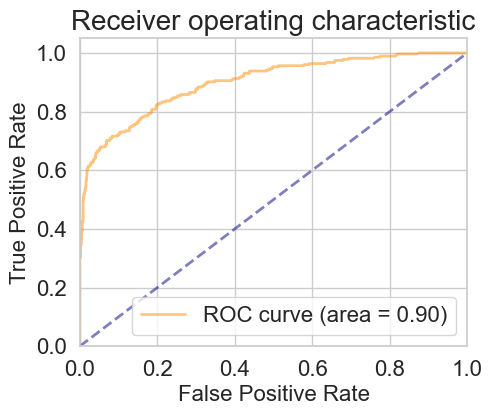

In [91]:
plt.figure(figsize=(5, 4))
lw=2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

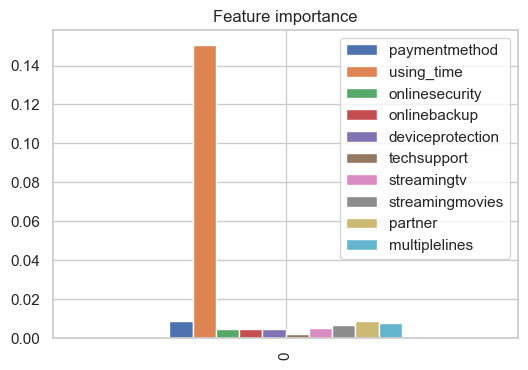

In [95]:
model_fi = permutation_importance(cbc, x_train.values,y_train.values)
fi = pd.DataFrame([model_fi['importances_mean']],columns=x_train.columns)
fi.plot(kind='bar',figsize=(6,4))
plt.title('Feature importance')
plt.show()

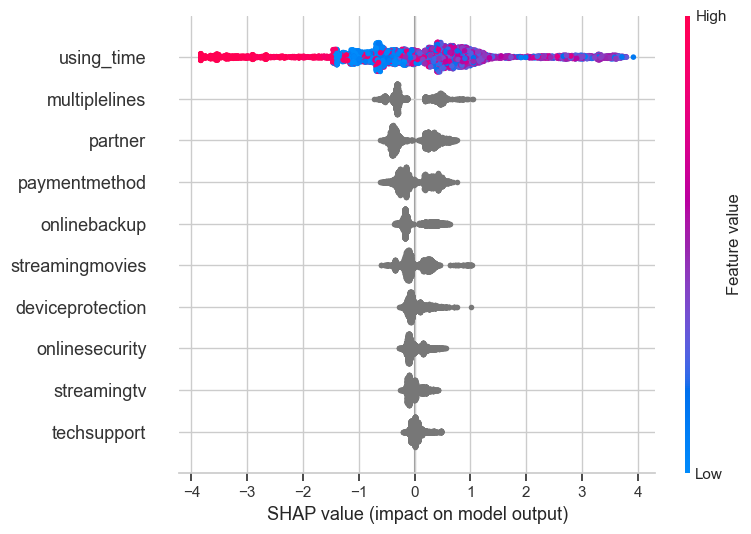

In [98]:
shap_test = shap.TreeExplainer(cbc).shap_values(x_train.values)
shap.summary_plot(shap_test, x_train,
                      max_display=25, auto_size_plot=True)

**Conclusion:** The gradient boosting model showed a good result with an AUC score of 0.92 on both the training and validation sets, indicating that the model did not overfit. The most important feature was found to be the duration of service usage, which is intuitive.

**Final Conclusion:**

- In the first part, the data was explored and prepared, including feature investigation and initial data processing.
- In the second part, feature preparation was conducted, and the target feature was created. After checking the correlation, correlated features were removed, and the dataset was divided into training and testing sets.
- In the third part, three models were trained: logistic regression (0.7), random forest (0.8), and gradient boosting (0.92). The gradient boosting model showed the best performance.
- In the final part, the CatBoost model was tested and achieved the desired accuracy. It was also demonstrated that the duration of service usage is the most important feature, with significant importance.

# Report

The project execution consisted of three stages and followed the planned schedule.

**The first stage** was data preprocessing. During the data exploration, two errors were identified in the records. The date fields were in string format, and the payment field had an object type instead of a numeric type. The missing values in the data were filled with blank spaces instead of NaN (only 11 clients had missing payment values, and they were removed). All tables were merged into one, and a target feature was added. The date fields were replaced with a field indicating the duration of usage.

All necessary graphs were plotted. A class imbalance was detected, with churned users being less than 5 times the number of retained users. Using the phik library, a correlation matrix was constructed, and highly correlated features were removed to avoid multicollinearity.

The population was divided into a training set and a test set in a 1:4 ratio. The features used for model training were 'paymentmethod', 'using_time', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'partner', and 'multiplelines'. The random_state parameter was set to 80523, which corresponds to the project start date.

**On the second stage,** three models were selected and evaluated using cross-validation. The linear model showed a result of 0.72, the random forest achieved 0.8, and the gradient boosting performed the best with a score of 0.92. By varying the parameters, the best result was obtained with the CatBoostClassifier using iterations=150 and learning_rate=0.5.

The model was evaluated on the test set and showed a good result with a ROC-AUC score of 0.9. A ROC curve was plotted, and feature importance analysis was conducted. The most important feature was found to be the usage time, which is highly logical.